In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD
import re

In [2]:
# Load the datasets
train_essays = pd.read_csv('train_essays.csv')

In [3]:
# Load the new dataset
ext_train_essays = pd.read_csv('train_v2_drcat_02.csv')

In [4]:
train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [5]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [6]:
ext_train_essays

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [7]:
ext_train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [8]:
# Ensure columns match
ext_train_essays = ext_train_essays.rename(columns={'label': 'generated'})
ext_train_essays = ext_train_essays[['text', 'generated']]

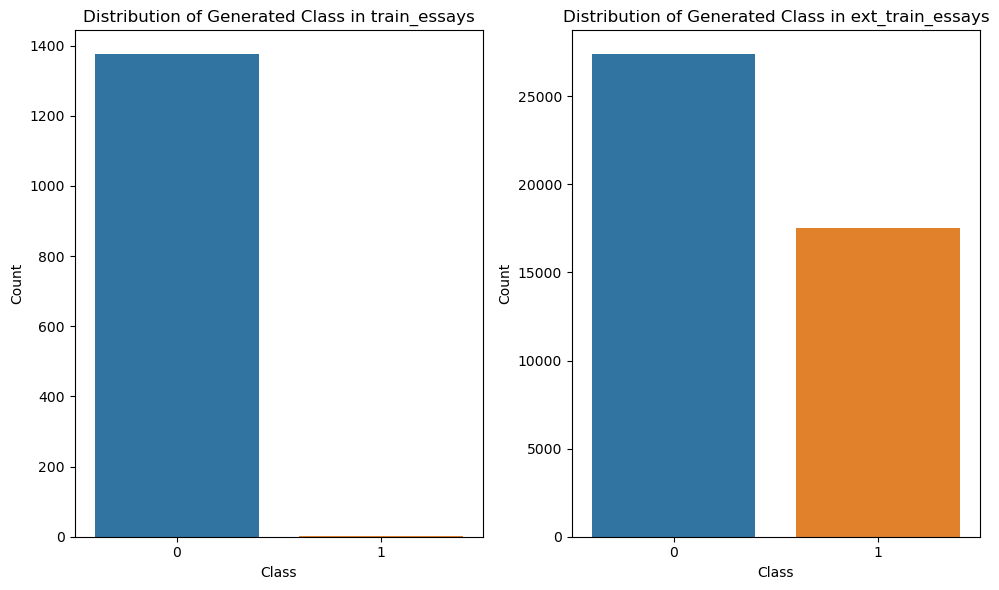

In [9]:

# Calculate class counts
train_class_counts = train_essays['generated'].value_counts()
ext_train_class_counts = ext_train_essays['generated'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=train_class_counts.index, y=train_class_counts.values)
plt.title('Distribution of Generated Class in train_essays')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x=ext_train_class_counts.index, y=ext_train_class_counts.values)
plt.title('Distribution of Generated Class in ext_train_essays')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
train_class_counts

generated
0    1375
1       3
Name: count, dtype: int64

In [11]:
ext_train_class_counts

generated
0    27371
1    17497
Name: count, dtype: int64

In [12]:
full_train_essays = pd.concat([train_essays[['text', 'generated']], ext_train_essays], ignore_index=True)

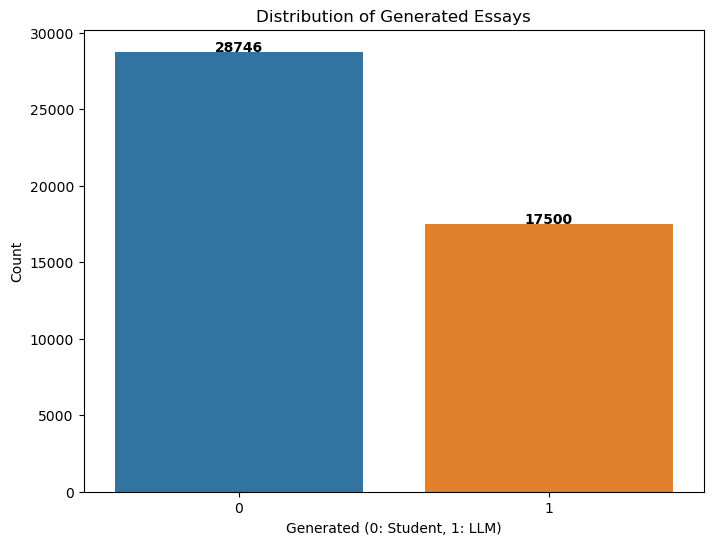

In [13]:
# Create the bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='generated', data=full_train_essays)

# Add the counts above the bars
generated_counts = full_train_essays['generated'].value_counts()

for index, value in enumerate(generated_counts):
    plt.text(index, value + 5, str(value), ha='center', fontweight='bold')

# Set the title and labels
plt.title('Distribution of Generated Essays')
plt.xlabel('Generated (0: Student, 1: LLM)')
plt.ylabel('Count')

# Display the plot
plt.show()

In [14]:
generated_counts

generated
0    28746
1    17500
Name: count, dtype: int64

                                                    text generated
23657  CELL PHONE POLICY!\n\nVery few people can deny...     Human
15798  Dear principal,\n\nI know you may be thinking ...     Human
862    Abolishing the Electoral College sounds like a...     Human
5393   Relaxing and warm, the summer approaches after...     Human
21578  The Electoral College should remaining our cou...     Human
...                                                  ...       ...
43165   Have you ever seen the Face on Mars and thoug...        AI
41931    Dear State Senator, \n\nI am writing to expr...        AI
28711  Reading books has been found to offer many ben...        AI
39300  As an 8th grader, I believe that having self-s...        AI
27465  The Importance of Positive Attitudes in Life\n...        AI

[35000 rows x 2 columns]


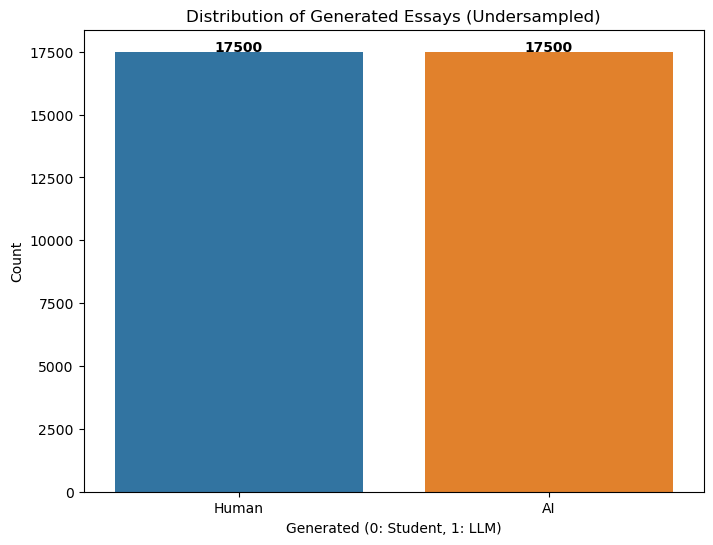

In [15]:
# Calculate target count
target_count = generated_counts.min()

# Oversample each class to reach the target count
oversampled_data = []
for label, count in generated_counts.items():
    class_data = full_train_essays[full_train_essays['generated'] == label]
    oversampled_class_data = resample(class_data, 
                                     replace=True,  # Sample with replacement
                                     n_samples=target_count, 
                                     random_state=42)  # For reproducibility
    oversampled_data.append(oversampled_class_data)

# Combine oversampled data
oversampled_data = pd.concat(oversampled_data)


# Assuming oversampled_data is your DataFrame
# Replace 0 with 'Human' and 1 with 'AI' in the 'generated' column
oversampled_data['generated'] = oversampled_data['generated'].replace({0: 'Human', 1: 'AI'})

# Now the 'generated' column has 'Human' for 0 and 'AI' for 1
print(oversampled_data)

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='generated', data=oversampled_data)

# Add the counts above the bars
oversampled_counts = oversampled_data['generated'].value_counts()
for index, value in enumerate(oversampled_counts):
    plt.text(index, value + 5, str(value), ha='center', fontweight='bold')

# Set the title and labels
plt.title('Distribution of Generated Essays (Undersampled)')
plt.xlabel('Generated (0: Student, 1: LLM)')
plt.ylabel('Count')

# Display the plot
plt.show()

In [16]:
oversampled_counts

generated
Human    17500
AI       17500
Name: count, dtype: int64

In [17]:
import re


def clean_text(text):
    # Remove Markdown headers (e.g., # Title, ## Subheading)
    text = re.sub(r'#[^\n]*', '', text)
    
    # Remove Markdown list items (e.g., - Item, * Item)
    text = re.sub(r'[-*]\s+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Replace newline characters with space
    text = re.sub(r'\n', ' ', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove numeric references (e.g., 1 Paragraph one.)
    text = re.sub(r'\d+\s+[\w\s]+', '', text)
    
    # Strip leading and trailing whitespace
    text = text.strip()
    
    return text


# Apply the text cleaning function
oversampled_data['text'] = oversampled_data['text'].apply(clean_text)


In [18]:
oversampled_data['text']

23657    CELL PHONE POLICY Very few people can deny tha...
15798    Dear principal I know you may be thinking that...
862      Abolishing the Electoral College sounds like a...
5393     Relaxing and warm the summer approaches after ...
21578    The Electoral College should remaining our cou...
                               ...                        
43165    Have you ever seen the Face on Mars and though...
41931    Dear State Senator I am writing to express my ...
28711    Reading books has been found to offer many ben...
39300    As an 8th grader I believe that having selfsuf...
27465    The Importance of Positive Attitudes in Life A...
Name: text, Length: 35000, dtype: object

In [19]:
mean_scores = []


In [20]:
# Assuming 'oversampled_data' is a pandas DataFrame
# Define the features and the target
X = oversampled_data['text']
y = oversampled_data['generated']

# Define a list of classifiers
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear'),  # Changed to linear kernel
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1)  # Reduced number of trees and enabled parallel processing
}

best_classifier_name = None
best_classifier_score = 0
best_classifier = None

for name, classifier in classifiers.items():
    print(f"Evaluating {name} using cross-validation...")
    
    # Create a pipeline
    if name == "Multinomial Naive Bayes":
        # MultinomialNB cannot handle negative values, so no TruncatedSVD
        model = make_pipeline(TfidfVectorizer(), classifier)
    else:
        # Other classifiers with TruncatedSVD
        model = make_pipeline(
            TfidfVectorizer(),
            TruncatedSVD(n_components=100),  # Reduce dimensionality to speed up the process
            classifier
        )
    
    # Perform cross-validation with 5 folds
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    # Print the cross-validation scores
    mean_score = cv_scores.mean()
    mean_scores.append((name, mean_score))
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {mean_score:.4f}")
    print("=" * 50)
    
    # Update the best classifier if this one is better
    if mean_score > best_classifier_score:
        best_classifier_name = name
        best_classifier_score = mean_score
        best_classifier = model

print(f"The best classifier is {best_classifier_name} with a mean accuracy of {best_classifier_score:.4f}")

Evaluating Multinomial Naive Bayes using cross-validation...
Cross-validation scores: [0.952      0.94857143 0.95671429 0.94742857 0.95314286]
Mean accuracy: 0.9516
Evaluating Logistic Regression using cross-validation...
Cross-validation scores: [0.96328571 0.95871429 0.96671429 0.95571429 0.95914286]
Mean accuracy: 0.9607
Evaluating Support Vector Machine using cross-validation...
Cross-validation scores: [0.96342857 0.95942857 0.96814286 0.95885714 0.96142857]
Mean accuracy: 0.9623
Evaluating Random Forest using cross-validation...
Cross-validation scores: [0.98328571 0.984      0.98542857 0.98428571 0.98257143]
Mean accuracy: 0.9839
The best classifier is Random Forest with a mean accuracy of 0.9839


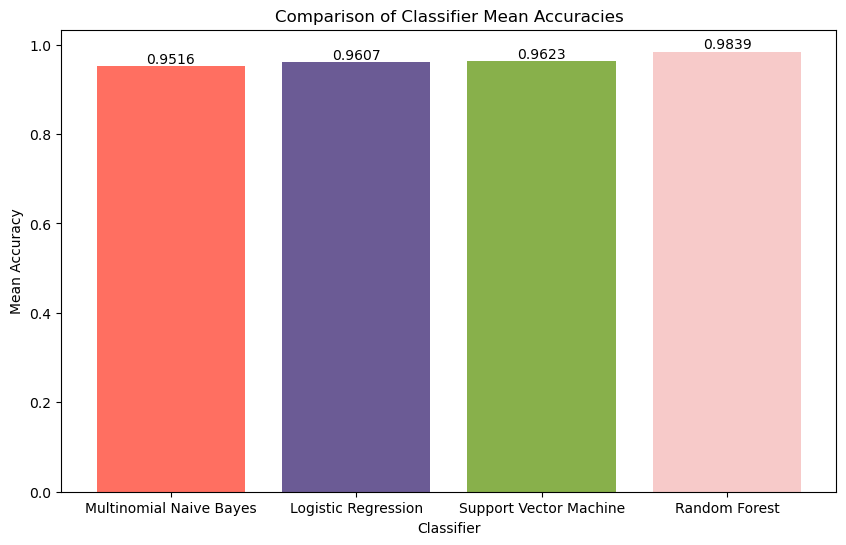

In [21]:
# Plotting the mean scores with vibrant colors and values above the bars
classifier_names = [name for name, score in mean_scores]
scores = [score for name, score in mean_scores]

# Define vibrant colors
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#B565A7', '#009B77', '#EAD94C', '#5DADE2', '#D4AC0D', '#AF601A']

plt.figure(figsize=(10, 6))
bars = plt.bar(classifier_names, scores, color=colors)
plt.xlabel('Classifier')
plt.ylabel('Mean Accuracy')
plt.title('Comparison of Classifier Mean Accuracies')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.show()

In [22]:
# Train the final model on the entire dataset
print(f"Training the classifier  on the entire dataset...")
best_classifier.fit(X, y)

Training the classifier  on the entire dataset...


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('truncatedsvd', TruncatedSVD(n_components=100)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1))])

In [ ]:
model = joblib.load('your_model_file.joblib')

In [23]:
X_new = ["""
In the vast expanse of digital corridors, where 0s and 1s dance in a symphony of information, lies the realm of human interaction with machines. In this digital ecosystem, a myriad of voices, both human and artificial, converge to shape conversations, ideas, and understanding.

From the depths of algorithmic algorithms to the heights of linguistic acrobatics, the tapestry of communication unfolds, weaving together threads of knowledge, creativity, and curiosity. With each keystroke, a new possibility emerges, a new pathway for exploration and discovery.

In this age of interconnectedness, the boundaries between man and machine blur, giving rise to a new era of collaboration and co-creation. Together, humans and artificial intelligences embark on a journey of mutual learning and evolution, pushing the boundaries of what is possible.

Yet, amidst this digital tapestry, questions linger. What does it mean to be truly intelligent? Can machines ever truly understand the depths of human experience? As we navigate this brave new world, one thing remains certain: the power of language, both human and artificial, to shape our reality and illuminate the path forward.

So let us embrace the symphony of voices, the dance of algorithms, and the endless possibilities of the digital age. For in this realm of ones and zeros, the future is ours to shape, and the journey is only just beginning.
"""]

In [24]:
# Use the best classifier to predict classifications for the new data
predictions_proba = model.predict_proba(X_new)
# Assuming best_classifier is your trained classifier
predicted_classes = best_classifier.classes_

# Map probabilities to their corresponding class labels
probability_map = {predicted_classes[i]: prob for i, prob in enumerate(predictions_proba[0])}

print("Probabilities of predictions:")
for label, prob in probability_map.items():
    print(f"Class: {label}, Probability: {prob}")



Probabilities of predictions:
Class: AI, Probability: 0.96
Class: Human, Probability: 0.04
